In [38]:
import pandas as pd
import requests
import json
import time
import urllib.request
import os



api_path = 'https://nrd.api.nhtsa.dot.gov/nhtsa/vehicle/api/v1/vehicle-database-test-results'

In [39]:
def get_car_assessement_data(size, dateFrom, dateTo):
  req_string = api_path + f'/by-search?count={size}&testType=NCA&excludeNhtsaVehicles=true&testDateFrom={dateFrom}&testDateTo={dateTo}'
  get_vehicles = requests.get(req_string)
  vehicles_json_results = json.loads(get_vehicles.text)['results']

  cleaned_results = map(lambda record: (record["testNo"], record["instrumentationInformation"]), filter(lambda rec: rec["hasInstrumentationInfo"] == True, vehicles_json_results))
  return cleaned_results

def save_car_assessement_as_json(data, filename):
  as_list = list(data)
  print(f'Found {len(as_list)} records matching the filters.\nDumping in file {filename}.')
  with open(filename, 'w') as f:
    json.dump(as_list, f)

def get_car_sensor_results(url):
  instruments_response = requests.get(url + '?count=1000')
  instruments_results = json.loads(instruments_response.text)['results']

  in_engine_results = filter(lambda record: record['sensorType'] == "ACCELEROMETER", instruments_results)
  return list(in_engine_results)

def save_car_sensor_results(url, filename):
  os.mkdir(filename)
  with open(filename + "/info", 'w') as f:
    values = get_car_sensor_results(url)
    json.dump(values, f)

def scrap_sensors_values(assess_filename, save_prefix):
  os.mkdir(save_prefix)
  with open(assess_filename, 'r') as f:
    dic = json.loads(f.read())
    for k, v in dic:
      save_car_sensor_results(v, f'{save_prefix}/{k}')
      time.sleep(0.5)
  print('End')

In [ ]:
# import argparse

# def run(args):
#   save_car_assessement_as_json(get_car_assessement_data(args['number'], args['date_from'], args['date_to']), args['filename'])
#   scrap_sensors_values(args['filename'], args['save_dir'])

# parser = argparse.ArgumentParser("crash_scrapper")
# parser.add_argument('filename', help='The file in which to save the data', type=str)
# parser.add_argument('number', help='The number of records to scrap (resulting json may be smaller)', type=int)
# parser.add_argument('save_dir', help='Directory in which to save', type=str)
# parser.add_argument('--date_from', help='Get records from this date (format: YYYY-MM-DD)', type=str, default='2000-01-01')
# parser.add_argument('--date_to', help='Get records to this date (format: YYYY-MM-DD)', type=str, default='2020-01-01')
# args = vars(parser.parse_args())

# run(args)

In [ ]:
def run(number, date_from, date_to, filename, save_dir):
    save_car_assessement_as_json(get_car_assessement_data(number, date_from, date_to), filename)
    scrap_sensors_values(filename, save_dir)


run(100, "2000-01-01", '2020-01-01', "data", "./save")

In [78]:
class Crashtest():

    def __init__(self, test_no, path='./save', capteurs_list=["B PILLAR - LEFT","A PILLAR - LEFT","VEHICLE CG"]):
        self.test_no = test_no
        self.path = path
        self.capteurs_list = capteurs_list
        self.info = {k: [] for k in capteurs_list}

    def get_info(self):
        with open(f'{self.path}/{self.test_no}/info', 'r') as f:
            list = json.loads(f.read())
            for test in list:
                if test["sensorAttachment"] in self.capteurs_list:
                    self.info[test["sensorAttachment"]].append({"axis": test["axisDirofSensor"][0], "curveNo" : test["curveNo"], 'vehicleNo': test["vehicleNo"]})

    def get_ascii_url(self):
        for k, v in self.info.items():
            for dict in v:
                response = requests.get(f'{api_path}/get-instrumentation-detail-info/{dict["curveNo"]}/{self.test_no}')
                if response.status_code == 200: 
                    result = response.json()['results'][0] 
                    dict["asciiFile"] = result["asciiFile"]
                else:
                    print(f"Failed to get data for curveNo {dict['curveNo']} with status code {response.status_code}")

    def get_full_path(self, k, dict):
        return f'{self.path}/{self.test_no}/{k}_ve{dict["vehicleNo"]}_{dict["axis"]}_{dict["curveNo"]}' 

    def download(self):
        for k, v in self.info.items():
            for dict in v:
                urllib.request.urlretrieve(dict["asciiFile"], self.get_full_path(k, dict))
                time.sleep(0.05)


    def clean(self):
        for k, v in self.info.items():
            for dict in v:
                file_path = self.get_full_path(k, dict)
                if os.path.exists(file_path):
                    os.remove(file_path)
        

    def load(self, prefix = lambda k : ''):
        merged_df = None
        for k, v in self.info.items():
            for dict in v:
                file_path = self.get_full_path(k, dict)
                df = pd.read_csv(file_path, delim_whitespace=True, header=None)
                df.columns = ['time', f'{prefix(k)}ve{dict["vehicleNo"]}_{dict["axis"]}_acc']
                df[f'{prefix(k)}ve{dict["vehicleNo"]}_{dict["axis"]}_acc'] = df[f'{prefix(k)}ve{dict["vehicleNo"]}_{dict["axis"]}_acc'] * 9.81
        
                if merged_df is None:
                    merged_df = df
                else:
                    merged_df = merged_df.merge(df, on='time', how='outer')
        return merged_df


# import urllib.request
# url = 'https://address'
# filename = 'myfile.txt'
# urllib.request.urlretrieve(url, filename)

In [80]:
T = Crashtest(3249, capteurs_list=["VEHICLE CG"])
T.get_info()
print(T.info)
T.get_ascii_url()
print(T.info)
T.download()

{'VEHICLE CG': [{'axis': 'X', 'curveNo': 47, 'vehicleNo': 2}, {'axis': 'Y', 'curveNo': 48, 'vehicleNo': 2}, {'axis': 'Z', 'curveNo': 49, 'vehicleNo': 2}, {'axis': 'X', 'curveNo': 50, 'vehicleNo': 1}, {'axis': 'Y', 'curveNo': 51, 'vehicleNo': 1}, {'axis': 'Z', 'curveNo': 52, 'vehicleNo': 1}]}
{'VEHICLE CG': [{'axis': 'X', 'curveNo': 47, 'vehicleNo': 2, 'asciiFile': 'https://nrd-static.nhtsa.dot.gov/tsv/vehdb/v00000/v03200/v03249/v03249tsv.047'}, {'axis': 'Y', 'curveNo': 48, 'vehicleNo': 2, 'asciiFile': 'https://nrd-static.nhtsa.dot.gov/tsv/vehdb/v00000/v03200/v03249/v03249tsv.048'}, {'axis': 'Z', 'curveNo': 49, 'vehicleNo': 2, 'asciiFile': 'https://nrd-static.nhtsa.dot.gov/tsv/vehdb/v00000/v03200/v03249/v03249tsv.049'}, {'axis': 'X', 'curveNo': 50, 'vehicleNo': 1, 'asciiFile': 'https://nrd-static.nhtsa.dot.gov/tsv/vehdb/v00000/v03200/v03249/v03249tsv.050'}, {'axis': 'Y', 'curveNo': 51, 'vehicleNo': 1, 'asciiFile': 'https://nrd-static.nhtsa.dot.gov/tsv/vehdb/v00000/v03200/v03249/v03249ts

In [81]:
df = T.load()

In [82]:
df

,time,ve2_X_acc,ve2_Y_acc,ve2_Z_acc,ve1_X_acc,ve1_Y_acc,ve1_Z_acc
0,-0.02000,-0.444124,1.332757,-12.293598,32.007381,74.291326,-22.722805
1,-0.01995,0.759147,-1.216303,-10.943251,-11.744826,66.136764,-19.755869
2,-0.01990,1.059961,-6.314432,-3.141525,-27.317613,37.293794,-16.492082
3,-0.01985,1.661598,-9.013438,5.110294,-3.587595,12.226105,-6.701044
4,-0.01980,2.413643,-5.564703,5.110294,16.879478,9.658946,7.985585
...,...,...,...,...,...,...,...
4395,0.19975,1.661598,-21.908673,143.590932,-8.926845,-22.355224,23.858999
4396,0.19980,3.917731,-26.706940,143.440839,-4.329163,-10.274405,26.232627
4397,0.19985,3.616918,-27.906507,143.590932,2.344904,14.491234,17.034967
4398,0.19990,0.759147,-24.907590,143.290746,7.832461,29.441282,5.463640


In [79]:
T.clean()

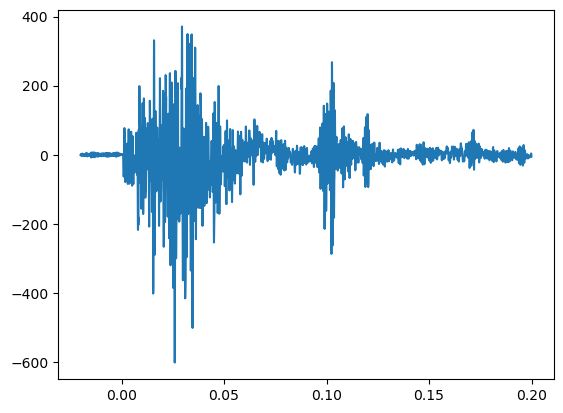

In [84]:
import matplotlib.pyplot as plt

plt.plot(df["time"],df["ve2_X_acc"])

In [86]:
acc_col = f've2_X_acc'
speed_col = f'speed'

df[speed_col] = 0
    
for j in range(1, len(df)):
    dt = df['time'].iloc[j] - df['time'].iloc[j-1]
    df[speed_col].iloc[j] = df[speed_col].iloc[j-1] + 0.5 * (df[acc_col].iloc[j] + df[acc_col].iloc[j-1]) * dt


C:\Users\joris\AppData\Local\Temp\ipykernel_15136\988952108.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[speed_col].iloc[j] = df[speed_col].iloc[j-1] + 0.5 * (df[acc_col].iloc[j] + df[acc_col].iloc[j-1]) * dt


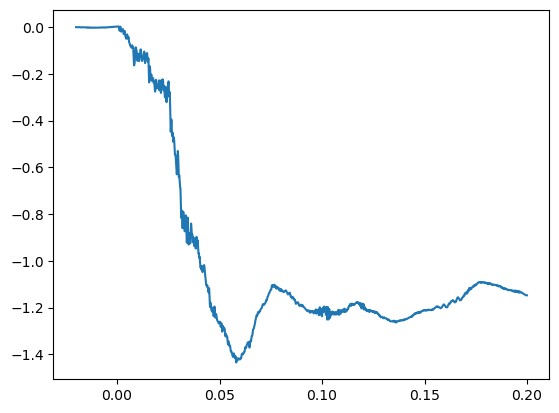

In [87]:
plt.plot(df["time"],df["speed"])

In [88]:
speed_col = f'speed'
pos_col = f'pos'

df[pos_col] = 0
    
for j in range(1, len(df)):
    dt = df['time'].iloc[j] - df['time'].iloc[j-1]
    df[pos_col].iloc[j] = df[pos_col].iloc[j-1] + 0.5 * (df[speed_col].iloc[j] + df[speed_col].iloc[j-1]) * dt

C:\Users\joris\AppData\Local\Temp\ipykernel_15136\1105204907.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pos_col].iloc[j] = df[pos_col].iloc[j-1] + 0.5 * (df[speed_col].iloc[j] + df[speed_col].iloc[j-1]) * dt


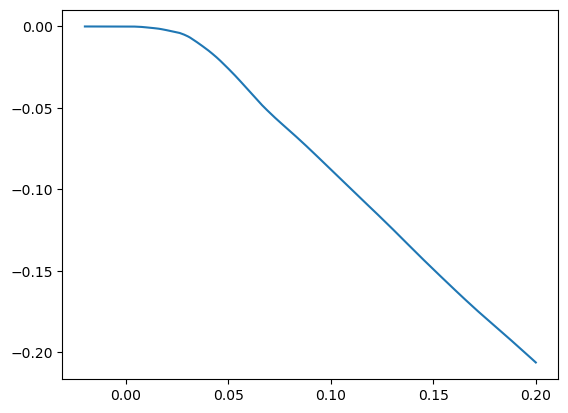

In [89]:
plt.plot(df["time"],df["pos"])